<a href="https://colab.research.google.com/github/kankeinai/machine-learning/blob/main/cat_and_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/cats_and_dogs')

In [ ]:
class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} #хранит названия директорий
    training_data= [] #сюда будем добавлять все картинки
    catcount = 0
    dogcount = 0 #считаем для того чтобы 
    #проверить сбаласирован ли датасет
    
    def make_training_data(self):
        for label in self.LABELS: #проходимся по двум директориям
            print(label)
            for f in tqdm(os.listdir(label)): #проходимся по всем файлам директории
                try:
                #tqdm добавляет шкалу загрузки
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))

                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount+=1
                    elif label== self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                    print(e)
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}, dogs: {self.dogcount}")

In [ ]:
if REBUILD_DATA:
    dogsVcats=DogsVsCats()
    dogsVcats.make_training_data()

In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [ ]:
print(len(training_data))

24946


In [ ]:
training_data[0] #it is a cat...

array([array([[170, 174, 171, ...,  85,  81,  81],
       [170, 174, 175, ...,  83,  84,  86],
       [168, 174, 173, ...,  93,  90,  92],
       ...,
       [147, 141, 186, ..., 136, 232, 183],
       [129, 134, 175, ..., 152, 203, 190],
       [122, 116, 155, ..., 164, 154, 190]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [ ]:
import matplotlib.pyplot as plt

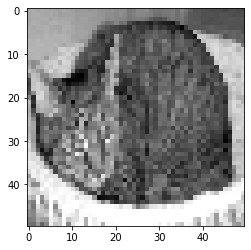

In [ ]:
plt.imshow(training_data[0][0], cmap='gray')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

cuda:0


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50) 
        #по сути создаем рандомный массив пикселей и чекаем его размер 
        #после того как он пройдет через все слои 
        
        self._to_linear=None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512) #чтобы узнать какой параметр инпут сюды
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self,x):
            
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
            
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1, self._to_linear)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x, dim = 1)
            
        

In [ ]:
def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
print(loss)
        


NameError: ignored

In [ ]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class=torch.argmax(test_y[i])
      net_out = net(test_X[i].view(-1,1,50,50))[0]
      predicted_class = torch.argmax(net_out)
      if predicted_class == real_class:
        correct+=1
      total+=1
print("Acurracy: ", round(correct/total, 3))


In [ ]:
net = Net()

In [ ]:
net.to(device)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])


In [ ]:
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
val_size

In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

len(train_X), len(test_X)

In [ ]:
BATCH_SIZE = 100
EPOCHS = 20

In [ ]:
train(net)
        

In [ ]:
te

In [ ]:
net.state_dict()